<a href="https://colab.research.google.com/github/mariampinel/Neural-Networks-Deep-Learning/blob/main/NN_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision

# Task 1: Create a DataLoader for the training dataset and a DataLoader for the testing dataset, which should enable generating batches of examples

In [6]:
# Load data
# You don't need to understand this function for now.
def load_data_cifar10(batch_size, resize=None):
    """Download the CIFAR-10 dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [7]:
# Create train and test split
batch_size = 256 # Defines the batch size
train_iter, test_iter = load_data_cifar10(batch_size) # `train_iter` and `test_iter` are `DataLoader` objects.

100%|██████████| 170M/170M [00:03<00:00, 55.5MB/s]


In [8]:
# Create vars X and y
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 256 images per batch. Each image is represented by a 1 x 28 x 28 tensor (number of channels x height x width). The images are grayscale, so there is a single channel.
print(y.size()) # 256 targets. Each target is a number between 0 and 9. The classification problem has 10 clases.

torch.Size([256, 3, 32, 32])
torch.Size([256])



Image 0 (truck):



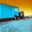


Image 1 (ship):



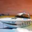


Image 2 (truck):



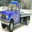


Image 3 (dog):



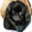


Image 4 (dog):



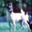

In [10]:
# Visualize data
from google.colab.patches import cv2_imshow

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Pre-defined class labels

for i in range(5):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # Prints the index `i` and the label associated to the `i`-th image.
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # Converts and displays the `i`-th image in the batch.

# Task 2

In [ ]:
# References
Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.